LSTM Autoencoder model and scaler loaded successfully.
Loaded 6521 data points from validation datasets.

Missing values in 'label' column replaced with 'Normal'.
Created 6463 sequences for validation.
Anomaly scores (Reconstruction Error) calculated.

True Label Distribution (for sequences):
true_label_mapped_multi
Normal      6415
Warning       31
Critical      17
Name: count, dtype: int64

--- Starting Threshold Optimization ---
Anomaly Score (Reconstruction Error) Range: 0.001125 to 7.605759
Testing 247 threshold candidates...
Progress: 0/247 critical thresholds tested...
Progress: 50/247 critical thresholds tested...
Progress: 100/247 critical thresholds tested...
Progress: 150/247 critical thresholds tested...
Progress: 200/247 critical thresholds tested...

Optimization completed!
Total combinations tested: 30381
Valid combinations: 30381

OPTIMAL THRESHOLDS FOR DIFFERENT OBJECTIVES (LSTM Autoencoder)

--- Weighted F1-Score Optimization ---
Best Weighted F1-Score: 0.9865
Critica

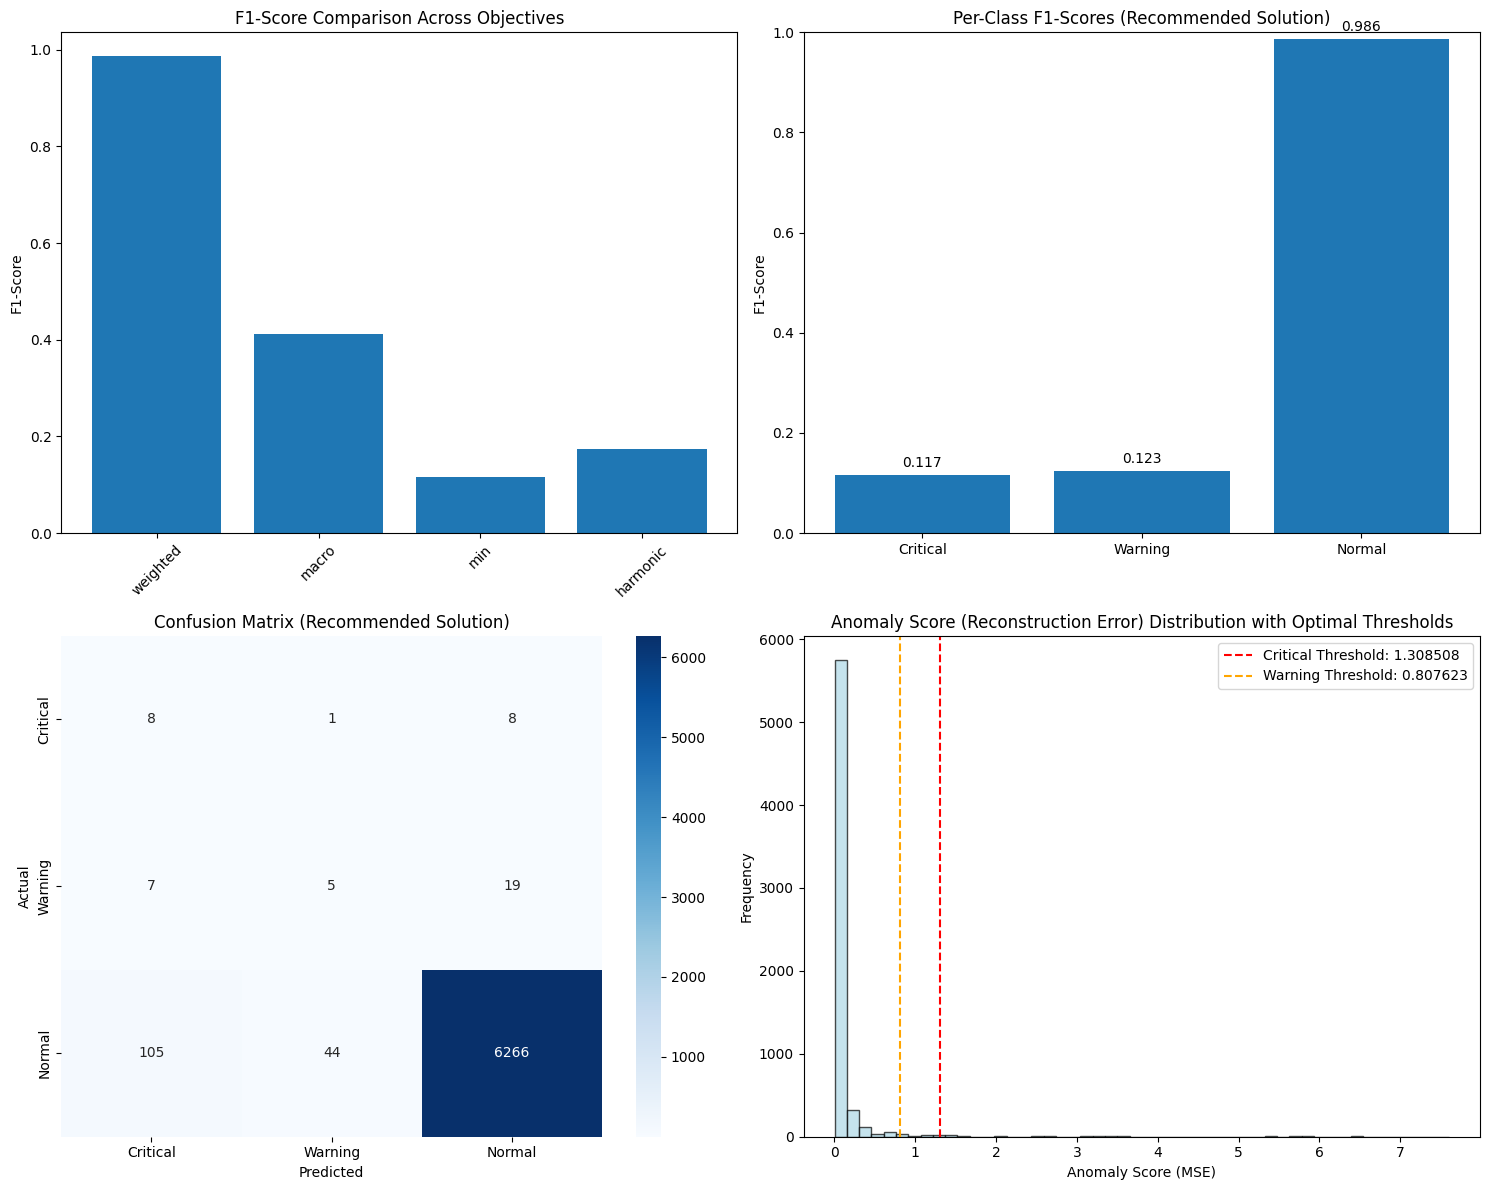


SUMMARY FOR IMPLEMENTATION (LSTM Autoencoder)

# Use these optimized thresholds in your code:
crit_thresh_lstm = 1.308508
warn_thresh_lstm = 0.807623

# Function to classify risk for LSTM Autoencoder:
def classify_risk_lstm(reconstruction_error):
    if reconstruction_error > 1.308508:
        return "Critical"
    elif reconstruction_error > 0.807623:
        return "Warning"
    else:
        return "Normal"

# Performance achieved with recommended thresholds:
# - Weighted F1-Score: 0.9797
# - Macro F1-Score: 0.4088
# - Minimum F1-Score: 0.1168
# - F1-Score per class: [0.11678832 0.12345679 0.98615046]



In [9]:
import pandas as pd
import numpy as np
from joblib import load
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from tensorflow.keras.models import load_model 
import warnings
import joblib
warnings.filterwarnings('ignore')

# --- Configuration ---
SEQUENCE_LENGTH = 30
numerical_cols = [
    'soil_mean', 'rain_mean', 'temp_mean', 'humi_mean', 'geo_mean'
]
label_order = ['Critical', 'Warning', 'Normal']

# --- 1. Load LSTM Autoencoder model, scaler, and datasets ---
try:
    scaler = joblib.load('scaler.save') # Adjust path if your scaler is elsewhere
    # This is where 'model' is defined!
    model = load_model('lstm_autoencoder_model.h5', compile=False)
    print("LSTM Autoencoder model and scaler loaded successfully.")
except FileNotFoundError as e:
    print(f"Error loading files: {e}")
    print("Make sure 'scaler.save' and 'lstm_autoencoder_model.h5' are in the correct directory.")
    exit()
except Exception as e:
    print(f"An unexpected error occurred during model loading: {e}")
    exit()

df1 = pd.read_csv("./../../data/dev101_resample10T_flex.csv")
df2 = pd.read_csv("./../../data/dev102_resample10T_flex.csv")
df_val = pd.concat([df1, df2], ignore_index=True)

df_val['timestamp'] = pd.to_datetime(df_val['timestamp'])
df_val = df_val.sort_values('timestamp').reset_index(drop=True)

print(f"Loaded {len(df_val)} data points from validation datasets.")

# --- 2. Data Preprocessing & Sequence Creation ---
df_val['label'] = df_val['label'].fillna('Normal')
print("\nMissing values in 'label' column replaced with 'Normal'.")

# Check if all feature_cols exist
if not all(col in df_val.columns for col in numerical_cols):
    missing_cols = [col for col in numerical_cols if col not in df_val.columns]
    print(f"Error: Missing numerical columns in DataFrame: {missing_cols}")
    print("Please check your CSV files and 'numerical_cols' definition.")
    exit()

# Scale numerical columns using the loaded scaler
scaled_values_val = scaler.transform(df_val[numerical_cols])
df_val_scaled = df_val.copy() # Create a copy to store scaled values
for i, col in enumerate(numerical_cols):
    df_val_scaled[f'scaled_{col}'] = scaled_values_val[:, i]

# Re-define create_sequences_by_device if not already in the environment
def create_sequences_by_device(df, sequence_length, numerical_cols, return_index=False):
    """
    สร้าง sequence สำหรับแต่ละ device (devID)
    Args:
        df: DataFrame ที่เตรียมข้อมูลแล้วและมีคอลัมน์ scaled_
        sequence_length: ความยาว sequence
        numerical_cols: รายชื่อคอลัมน์ feature ดั้งเดิม (จะใช้ scaled_col)
        return_index: คืนค่า original index ของแถวสุดท้ายในแต่ละ sequence หรือไม่
    Returns:
        sequences: np.array (num_seq, seq_len, num_feat)
        device_ids: รายชื่อ devID ของแต่ละ sequence
        timestamps: timestamp สุดท้ายของแต่ละ sequence
        (option) last_indices: index ของแถวสุดท้ายในแต่ละ sequence (ใน df)
    """
    sequences = []
    device_ids = []
    timestamps = []
    last_indices = []
    groupby_obj = df.groupby('devID')
    
    # Ensure all scaled columns are present
    scaled_feature_cols = [f'scaled_{col}' for col in numerical_cols]
    if not all(col in df.columns for col in scaled_feature_cols):
        raise ValueError(f"Missing scaled feature columns in DataFrame: {scaled_feature_cols}")

    for dev_id, group in groupby_obj:
        group = group.sort_values('timestamp')
        values = group[scaled_feature_cols].values
        time_vals = group['timestamp'].values
        idx_vals = group.index.values # Original index from df_val

        if len(values) >= sequence_length: # Ensure enough data to form at least one sequence
            for i in range(len(values) - sequence_length + 1):
                sequences.append(values[i:i + sequence_length])
                device_ids.append(dev_id)
                timestamps.append(time_vals[i + sequence_length - 1])
                if return_index:
                    last_indices.append(idx_vals[i + sequence_length - 1])
    
    if return_index:
        return np.array(sequences), device_ids, timestamps, last_indices
    else:
        return np.array(sequences), device_ids, timestamps

# Create sequences for validation
X_val_seq, val_device_ids, val_seq_timestamps, val_original_indices = \
    create_sequences_by_device(df_val_scaled, SEQUENCE_LENGTH, numerical_cols, return_index=True)

print(f"Created {len(X_val_seq)} sequences for validation.")

# Predict reconstruction with the autoencoder
reconstructed_sequences = model.predict(X_val_seq, verbose=0)

# Calculate Reconstruction Error (MSE per sequence)
# MSE = (actual - reconstructed)^2 / num_features, then mean over sequence length
# np.mean(np.square(X_val_seq - reconstructed_sequences), axis=(1, 2)) will give MSE for each sequence
df_val_seq_results = pd.DataFrame({
    'devID': val_device_ids,
    'timestamp': val_seq_timestamps,
    'original_index': val_original_indices
})

# Ensure labels are aligned with sequences
# We need the true label for the LAST point in each sequence
df_val_seq_results['true_label'] = df_val.loc[df_val_seq_results['original_index'], 'label'].values
df_val_seq_results['anomaly_score'] = np.mean(np.square(X_val_seq - reconstructed_sequences), axis=(1, 2))

print("Anomaly scores (Reconstruction Error) calculated.")

# Prepare true labels for evaluation
df_val_seq_results['true_label_mapped_multi'] = df_val_seq_results['true_label'].replace({
    'critical': 'Critical',
    'normal': 'Normal',
    'Normal': 'Normal', # Ensure consistency
    'warning': 'Warning'
})

# Filter out any unexpected labels if necessary, though the replace should handle it
df_val_filtered = df_val_seq_results[df_val_seq_results['true_label_mapped_multi'].isin(label_order)].copy()

print("\nTrue Label Distribution (for sequences):")
print(df_val_filtered['true_label_mapped_multi'].value_counts())

# --- 3. Threshold Optimization Function (Same as before) ---
def classify_risk_with_thresholds(scores, crit_thresh, warn_thresh):
    """Classify risk based on anomaly scores and thresholds"""
    conditions = [
        scores > crit_thresh, # For Reconstruction Error, higher means more anomalous (Critical)
        (scores <= crit_thresh) & (scores > warn_thresh), # Warning
        scores <= warn_thresh # Normal
    ]
    # Note: For Reconstruction Error, lower score is 'Normal', higher is 'Critical'
    # So Critical_Threshold should be higher than Warning_Threshold
    # Let's adjust the choices and conditions for MSE:
    # A high MSE is bad (Critical)
    # A low MSE is good (Normal)
    # So, if score > crit_thresh, it's Critical
    # If warn_thresh < score <= crit_thresh, it's Warning
    # If score <= warn_thresh, it's Normal
    choices = ['Critical', 'Warning', 'Normal']
    return np.select(conditions, choices, default='Normal')

def evaluate_thresholds(crit_thresh, warn_thresh, df_filtered):
    """Evaluate model performance with given thresholds"""
    y_pred = classify_risk_with_thresholds(df_filtered['anomaly_score'], crit_thresh, warn_thresh)
    y_true = df_filtered['true_label_mapped_multi']
    
    # Calculate F1-scores
    f1_weighted = f1_score(y_true, y_pred, average='weighted', labels=label_order, zero_division=0)
    f1_macro = f1_score(y_true, y_pred, average='macro', labels=label_order, zero_division=0)
    f1_per_class = f1_score(y_true, y_pred, average=None, labels=label_order, zero_division=0)
    
    # Handle cases where a class might have no true samples but is predicted, leading to empty arrays
    if len(f1_per_class) < len(label_order):
        # Create a full array, filling missing classes with 0
        f1_per_class_full = np.zeros(len(label_order))
        unique_true_labels = np.unique(y_true)
        for i, label in enumerate(label_order):
            if label in unique_true_labels:
                f1_per_class_full[i] = f1_score(y_true, y_pred, average=None, labels=[label], zero_division=0)[0]
        f1_per_class = f1_per_class_full

    f1_min = np.min(f1_per_class)
    f1_harmonic = len(f1_per_class) / np.sum(1.0 / (f1_per_class + 1e-10))
    
    return {
        'f1_weighted': f1_weighted,
        'f1_macro': f1_macro,
        'f1_per_class': f1_per_class,
        'f1_min': f1_min,
        'f1_harmonic': f1_harmonic,
        'y_pred': y_pred
    }

# --- 4. Grid Search for Optimal Thresholds ---
print("\n--- Starting Threshold Optimization ---")

# Get score range for threshold search
score_min = df_val_filtered['anomaly_score'].min()
score_max = df_val_filtered['anomaly_score'].max()
score_range = score_max - score_min

print(f"Anomaly Score (Reconstruction Error) Range: {score_min:.6f} to {score_max:.6f}")

# Create threshold candidates based on percentiles and score distribution
# For Reconstruction Error, lower percentiles are 'Normal', higher are 'Anomalous'
# So we want to search higher percentiles for thresholds
percentiles = np.arange(0.1, 99.9, 0.5)
score_percentiles = np.percentile(df_val_filtered['anomaly_score'], percentiles)

# Additional candidates around key high percentiles
key_high_percentiles = [70, 75, 80, 85, 90, 95, 97, 98, 99, 99.5]
additional_candidates = []
for p in key_high_percentiles:
    base_score = np.percentile(df_val_filtered['anomaly_score'], p)
    # Add small variations around each key percentile
    # Adjust offset values if needed based on the scale of your anomaly scores
    for offset_factor in [-0.01, -0.005, 0, 0.005, 0.01]: # Smaller offsets for more precise search around critical points
        additional_candidates.append(base_score + offset_factor * score_range)

# Combine all candidates and remove duplicates
all_candidates = np.concatenate([score_percentiles, additional_candidates])
all_candidates = np.unique(all_candidates)
# Ensure candidates are within the observed range
all_candidates = all_candidates[(all_candidates >= score_min) & (all_candidates <= score_max)]
all_candidates = np.sort(all_candidates) # Sort them for logical iteration

print(f"Testing {len(all_candidates)} threshold candidates...")

# Grid search with multiple optimization objectives
best_results = {
    'weighted': {'score': 0, 'crit_thresh': None, 'warn_thresh': None, 'results': None},
    'macro': {'score': 0, 'crit_thresh': None, 'warn_thresh': None, 'results': None},
    'min': {'score': 0, 'crit_thresh': None, 'warn_thresh': None, 'results': None},
    'harmonic': {'score': 0, 'crit_thresh': None, 'warn_thresh': None, 'results': None},
    'balanced': {'score': 0, 'crit_thresh': None, 'warn_thresh': None, 'results': None}
}

total_combinations = 0
valid_combinations = 0

# Iteration order: crit_thresh must be > warn_thresh for MSE (higher is more anomalous)
for i, crit_thresh in enumerate(all_candidates):
    if i % 50 == 0:
        print(f"Progress: {i}/{len(all_candidates)} critical thresholds tested...")
    
    for warn_thresh in all_candidates:
        if warn_thresh >= crit_thresh: # For MSE, warn_thresh must be LESS than crit_thresh
            continue 
        
        total_combinations += 1
        
        try:
            results = evaluate_thresholds(crit_thresh, warn_thresh, df_val_filtered)
            valid_combinations += 1
            
            # Update best results for different objectives
            if results['f1_weighted'] > best_results['weighted']['score']:
                best_results['weighted'].update({
                    'score': results['f1_weighted'],
                    'crit_thresh': crit_thresh,
                    'warn_thresh': warn_thresh,
                    'results': results
                })
            
            if results['f1_macro'] > best_results['macro']['score']:
                best_results['macro'].update({
                    'score': results['f1_macro'],
                    'crit_thresh': crit_thresh,
                    'warn_thresh': warn_thresh,
                    'results': results
                })
            
            if results['f1_min'] > best_results['min']['score']:
                best_results['min'].update({
                    'score': results['f1_min'],
                    'crit_thresh': crit_thresh,
                    'warn_thresh': warn_thresh,
                    'results': results
                })
            
            if results['f1_harmonic'] > best_results['harmonic']['score']:
                best_results['harmonic'].update({
                    'score': results['f1_harmonic'],
                    'crit_thresh': crit_thresh,
                    'warn_thresh': warn_thresh,
                    'results': results
                })
            
            # Balanced score: combination of minimum F1 and harmonic mean
            balanced_score = 0.6 * results['f1_min'] + 0.4 * results['f1_harmonic']
            if balanced_score > best_results['balanced']['score']:
                best_results['balanced'].update({
                    'score': balanced_score,
                    'crit_thresh': crit_thresh,
                    'warn_thresh': warn_thresh,
                    'results': results
                })
                
        except Exception as e:
            # This catch is mostly for debugging, in production, you might want more specific error handling
            # print(f"Error evaluating thresholds {crit_thresh}, {warn_thresh}: {e}")
            continue

print(f"\nOptimization completed!")
print(f"Total combinations tested: {total_combinations}")
print(f"Valid combinations: {valid_combinations}")

# --- 5. Display Results ---
print("\n" + "="*80)
print("OPTIMAL THRESHOLDS FOR DIFFERENT OBJECTIVES (LSTM Autoencoder)")
print("="*80)

objectives = [
    ('weighted', 'Weighted F1-Score'),
    ('macro', 'Macro F1-Score'),
    ('min', 'Minimum F1-Score (Worst Class)'),
    ('harmonic', 'Harmonic Mean F1-Score'),
    ('balanced', 'Balanced Score (Min + Harmonic)')
]

for obj_key, obj_name in objectives:
    best = best_results[obj_key]
    if best['results'] is not None:
        print(f"\n--- {obj_name} Optimization ---")
        print(f"Best {obj_name}: {best['score']:.4f}")
        print(f"Critical Threshold: {best['crit_thresh']:.6f}") # Display more precision for small MSE values
        print(f"Warning Threshold: {best['warn_thresh']:.6f}")
        print(f"F1-Score per class: {best['results']['f1_per_class']}")
        print(f"Weighted F1: {best['results']['f1_weighted']:.4f}")
        print(f"Macro F1: {best['results']['f1_macro']:.4f}")
        print(f"Minimum F1: {best['results']['f1_min']:.4f}")
        print(f"Harmonic Mean F1: {best['results']['f1_harmonic']:.4f}")

# --- 6. Recommended Solution (Balanced Approach) ---
print("\n" + "="*80)
print("RECOMMENDED SOLUTION (LSTM Autoencoder)")
print("="*80)

recommended = best_results['balanced']
if recommended['results'] is not None:
    print(f"Recommended Critical Threshold: {recommended['crit_thresh']:.6f}")
    print(f"Recommended Warning Threshold: {recommended['warn_thresh']:.6f}")
    print(f"Balanced Score: {recommended['score']:.4f}")
    
    # Apply recommended thresholds
    df_val_filtered['predicted_risk_optimized'] = classify_risk_with_thresholds(
        df_val_filtered['anomaly_score'], 
        recommended['crit_thresh'], 
        recommended['warn_thresh']
    )
    
    print("\nDetailed Classification Report:")
    print(classification_report(
        df_val_filtered['true_label_mapped_multi'], 
        df_val_filtered['predicted_risk_optimized'], 
        labels=label_order, 
        target_names=label_order,
        zero_division=0
    ))
    
    print("\nConfusion Matrix:")
    cm = confusion_matrix(
        df_val_filtered['true_label_mapped_multi'], 
        df_val_filtered['predicted_risk_optimized'], 
        labels=label_order
    )
    print(cm)
    
    print("\nPredicted Risk Distribution:")
    print(df_val_filtered['predicted_risk_optimized'].value_counts())

# --- 7. Visualization ---
def plot_threshold_comparison():
    """Plot comparison of different threshold strategies"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: F1-scores comparison
    objectives_plot = ['weighted', 'macro', 'min', 'harmonic']
    scores = [best_results[obj]['score'] for obj in objectives_plot]
    
    axes[0, 0].bar(objectives_plot, scores)
    axes[0, 0].set_title('F1-Score Comparison Across Objectives')
    axes[0, 0].set_ylabel('F1-Score')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # Plot 2: Per-class F1-scores for recommended solution
    if recommended['results'] is not None:
        f1_per_class = recommended['results']['f1_per_class']
        axes[0, 1].bar(label_order, f1_per_class)
        axes[0, 1].set_title('Per-Class F1-Scores (Recommended Solution)')
        axes[0, 1].set_ylabel('F1-Score')
        axes[0, 1].set_ylim(0, 1)
        
        # Add value labels on bars
        for i, v in enumerate(f1_per_class):
            axes[0, 1].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
    
    # Plot 3: Confusion Matrix Heatmap
    if recommended['results'] is not None:
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=label_order, yticklabels=label_order,
                    ax=axes[1, 0])
        axes[1, 0].set_title('Confusion Matrix (Recommended Solution)')
        axes[1, 0].set_xlabel('Predicted')
        axes[1, 0].set_ylabel('Actual')
    
    # Plot 4: Threshold visualization
    if recommended['results'] is not None:
        # Create a histogram of anomaly scores with threshold lines
        axes[1, 1].hist(df_val_filtered['anomaly_score'], bins=50, alpha=0.7, 
                        color='lightblue', edgecolor='black')
        axes[1, 1].axvline(recommended['crit_thresh'], color='red', linestyle='--', 
                          label=f'Critical Threshold: {recommended["crit_thresh"]:.6f}')
        axes[1, 1].axvline(recommended['warn_thresh'], color='orange', linestyle='--', 
                          label=f'Warning Threshold: {recommended["warn_thresh"]:.6f}')
        axes[1, 1].set_title('Anomaly Score (Reconstruction Error) Distribution with Optimal Thresholds')
        axes[1, 1].set_xlabel('Anomaly Score (MSE)')
        axes[1, 1].set_ylabel('Frequency')
        axes[1, 1].legend()
    
    plt.tight_layout()
    plt.show()

# Call the plotting function
plot_threshold_comparison()

# --- 8. Save Results ---
print("\n" + "="*80)
print("SUMMARY FOR IMPLEMENTATION (LSTM Autoencoder)")
print("="*80)

print(f"""
# Use these optimized thresholds in your code:
crit_thresh_lstm = {recommended['crit_thresh']:.6f}
warn_thresh_lstm = {recommended['warn_thresh']:.6f}

# Function to classify risk for LSTM Autoencoder:
def classify_risk_lstm(reconstruction_error):
    if reconstruction_error > {recommended['crit_thresh']:.6f}:
        return "Critical"
    elif reconstruction_error > {recommended['warn_thresh']:.6f}:
        return "Warning"
    else:
        return "Normal"

# Performance achieved with recommended thresholds:
# - Weighted F1-Score: {recommended['results']['f1_weighted']:.4f}
# - Macro F1-Score: {recommended['results']['f1_macro']:.4f}
# - Minimum F1-Score: {recommended['results']['f1_min']:.4f}
# - F1-Score per class: {recommended['results']['f1_per_class']}
""")